In [1]:
#import de bibliotecas
import os
import pandas as pd
import sagemaker_pyspark
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField,StringType, FloatType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import create_map, struct
from sagemaker_pyspark import classpath_jars

In [3]:
#Setando encoding correto
os.environ["PYTHONIOENCODING"] = "ASCII"

In [4]:
LANDED_PATH = '/home/leonardo/Documentos/TrabalhoConclusao/bruto/'
MODELED_PATH = '/home/leonardo/Documentos/TrabalhoConclusao/tratado/'
GRAPHIC_PATH = '/home/leonardo/Documentos/TrabalhoConclusao/graficos/'

In [5]:
classpath = ":".join(sagemaker_pyspark.classpath_jars())

builder = SparkSession.builder.appName("https://www.prf.gov.br/portal/dados-abertos/acidentes/acidentes")
builder.config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2")
builder.config("spark.speculation", "false")
builder.config("spark.sql.parquet.compression.codec", "gzip")
builder.config("spark.debug.maxToStringFields", "100")
builder.config("spark.driver.extraClassPath", classpath)
builder.config("spark.driver.memory", "1g")
builder.config("spark.driver.cores", "1")
builder.config("spark.executor-memory", "20g")
builder.config("spark.executor.cores", "4")

builder.master("local[*]")

spark = builder.getOrCreate()

In [6]:
all_dataset = [f'{LANDED_PATH}{file}' for file in os.listdir(LANDED_PATH) if '.csv' in file]
all_dataset

['/home/leonardo/Documentos/TrabalhoConclusao/bruto/datatran2019.csv']

In [7]:
def set_dafault_value(df):
    df['data_inversa'] = df['data_inversa'].replace('', '00-00-00', regex=True)
    df['dia_semana'] = df['dia_semana'].replace('', 'NAO_INFORMADO', regex=True)
    df['uf'] = df['uf'].replace('', 'NN', regex=True)

    return df

In [8]:
dataset_list = spark.sparkContext.parallelize(all_dataset).map(lambda file: pd.read_csv(file, sep=';', error_bad_lines=False, encoding = "ISO-8859-1")).map(lambda df: df.apply(lambda row: row.strip() if isinstance(row, str) else row, axis=1)).map(lambda df: set_dafault_value(df)).map(lambda df: df.drop(["municipio"], axis=1)).reduce(lambda df_1, df_2: df_1.append(df_2, ignore_index=True))

In [9]:
dataset_list.to_parquet(f'{MODELED_PATH}final_dataset.parquet', engine='fastparquet', compression='gzip')

In [10]:
dataframe = pd.read_parquet(f'{MODELED_PATH}final_dataset.parquet', engine='fastparquet')

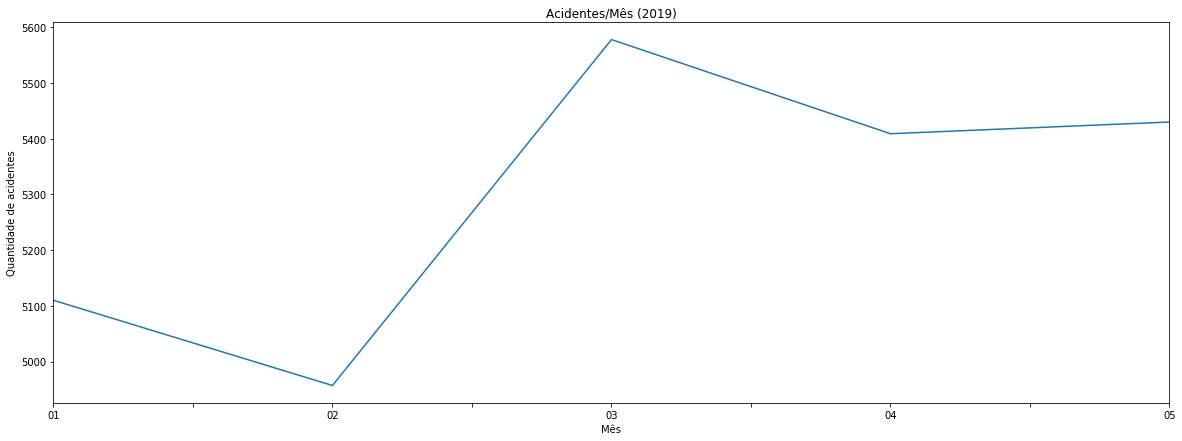

In [17]:
df = copy.deepcopy(dataframe)

df['data_inversa'] = pd.to_datetime(df['data_inversa'], errors='coerce')

df = df.sort_values('data_inversa')

df = df.groupby(by=[df['data_inversa'].dt.strftime('%m')])['id'].count()

df.plot()

plt.title('Acidentes/Mês (2019)')
plt.xlabel('Mês')
plt.ylabel('Quantidade de acidentes')
plt.savefig(f'{GRAPHIC_PATH}Mes_Quantidade_Acidentes.png')
plt.show()

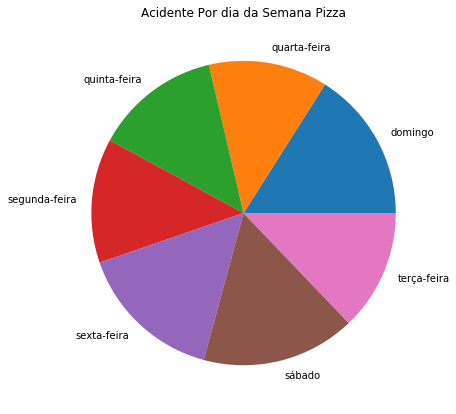

In [16]:
df = copy.deepcopy(dataframe)

df = df.sort_values('dia_semana')

df = df.groupby(df['dia_semana'])['id'].count().reset_index(name="count")

plt.pie(df['count'],  labels=df['dia_semana'])
plt.title('Acidente Por dia da Semana Pizza')
plt.savefig(f'{GRAPHIC_PATH}AcidentePorDiasSemana.png')
plt.show()

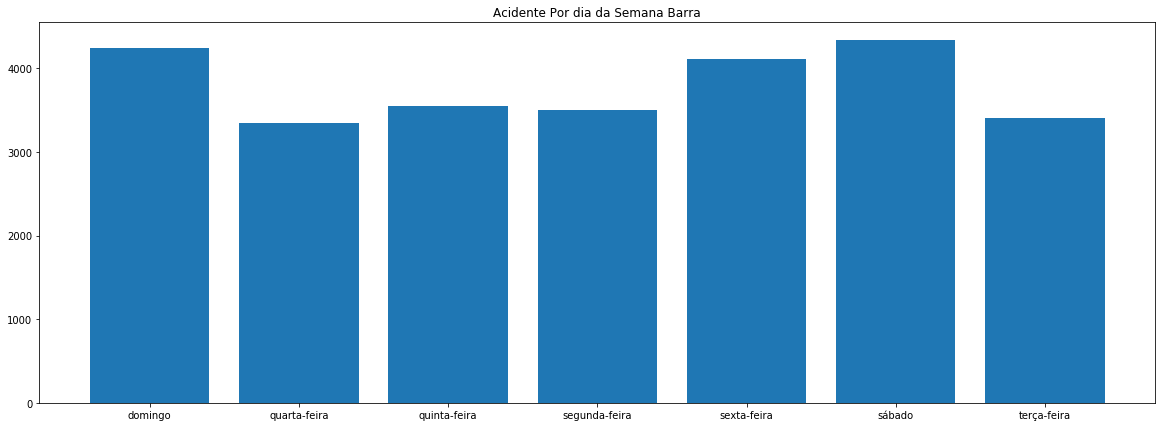

In [15]:
df = copy.deepcopy(dataframe)

df = df.sort_values('dia_semana')

df = df.groupby(df['dia_semana'])['id'].count().reset_index(name="count")

plt.bar(df['dia_semana'], df['count'])
plt.title('Acidente Por dia da Semana Barra')
plt.savefig(f'{GRAPHIC_PATH}AcidentePorDiasSemanaBarra.png')
plt.rcParams['figure.figsize'] = (20,7)
plt.show()